# Entrenamiento ML

Por: Daning Montaño

## Importar librerías

In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import os
import mlflow
from mlflow.tracking import MlflowClient
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import linregress

## Carga de datos

In [2]:
df_gedi = pd.read_csv("DATA/df_union_gedi.csv").dropna()
df_gedi.columns

Index(['RFDI', 'DPDD', 'DpRVIVV', 'VH', 'VV', 'B11', 'B11_contrast',
       'B11_corr', 'B11_diss', 'B11_ent', 'B11_var', 'B12', 'B2', 'B3', 'B4',
       'B8', 'EVI', 'GCI', 'MSAVI', 'NDMI', 'NDVI', 'SAVI', 'Slope',
       'elevation', 'N_efectivo_estratos', 'lon', 'lat', 'DpRVIHH', 'HH', 'HV',
       'HV_contrast', 'HV_corr', 'HV_diss', 'HV_ent', 'HV_var'],
      dtype='object')

In [3]:
df_gedi.head()

,RFDI,DPDD,DpRVIVV,VH,VV,B11,B11_contrast,B11_corr,B11_diss,B11_ent,...,lon,lat,DpRVIHH,HH,HV,HV_contrast,HV_corr,HV_diss,HV_ent,HV_var
0,0.147805,0.181490,0.686560,0.044054,0.212611,1402.5,9.680916e+11,0.584645,621104.545455,4.770975,...,-77.476179,-1.117864,1.704391,4888.5,3629.5,2.891250e+07,0.211371,4273.364773,5.345972,1.827252e+07
1,0.198458,0.089690,0.905287,0.028707,0.098134,1550.0,8.835777e+11,0.534480,610385.227273,4.770975,...,-77.476179,-1.118134,1.603085,5595.0,3742.0,2.763441e+07,0.282679,4200.443182,5.345972,1.928422e+07
2,-0.048516,0.229352,0.503965,0.040866,0.283487,1488.5,9.679577e+11,0.702365,645921.590909,4.708395,...,-77.475910,-1.118673,2.097031,3942.0,4344.0,3.168169e+07,0.263496,4436.804545,5.345972,2.145946e+07
3,0.130420,0.145603,0.909069,0.046798,0.159116,1104.5,7.593858e+11,0.585595,524107.954545,4.770975,...,-77.475371,-1.118942,1.739160,4934.0,3795.5,3.218097e+07,0.304248,4364.476136,5.345972,2.320166e+07
4,0.269977,0.228092,0.577314,0.046556,0.276014,1411.0,6.108494e+11,0.610041,456927.272727,4.739855,...,-77.475101,-1.119481,1.460045,5038.0,2896.0,3.747875e+07,0.350021,4808.880682,5.345972,2.874796e+07


## Carga de Funciones

In [4]:
def kling_gupta_efficiency(y_obs, y_pred):
    # 1) correlación
    r    = np.corrcoef(y_obs, y_pred)[0,1]
    # 2) sesgo de medias
    beta = y_pred.mean() / y_obs.mean()
    # 3) razón de coeficientes de variación
    cv_obs  = y_obs.std(ddof=1)  / y_obs.mean()
    cv_pred = y_pred.std(ddof=1) / y_pred.mean()
    gamma = cv_pred / cv_obs
    
    # 4) fórmula KGE
    return 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

## Entrenamiento de ML

### Creación de ambiente en MLFlows

In [5]:

# 1. Definir carpeta local para almacenar experimentos
project_root = os.getcwd()
mlruns_path  = os.path.join(project_root, "MLRUNS")
os.makedirs(mlruns_path, exist_ok=True)

# 2. Apuntar MLflow al file-store local (evita latencia HTTP)
#    En Windows, usar file:/// con tres barras o ruta sin prefijo.
mlflow.set_tracking_uri(f"file:///{mlruns_path.replace(os.sep, '/')}")

# 3. Crear o seleccionar experimento
experiment_name = "GEDI_structure"
mlflow.set_experiment(experiment_name)

2025/05/22 09:48:22 INFO mlflow.tracking.fluent: Experiment with name 'GEDI_structure' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/ACADEMICO/UTPL/herramientas_inteligencia_artificial/PROYECTO_FINAL/GEDI_STRUCTURE_ML/ML/MLRUNS/757720343699109491', creation_time=1747925302140, experiment_id='757720343699109491', last_update_time=1747925302140, lifecycle_stage='active', name='GEDI_structure', tags={}>

### Random Forest - Todas las variables

#### Selección de variables

In [6]:
variables_predictoras =['RFDI', 'DPDD', 'DpRVIVV', 'VH', 'VV', 'B11', 'B11_contrast', ## variables predictoras
       'B11_corr', 'B11_diss', 'B11_ent', 'B11_var', 'B12', 'B2', 'B3', 'B4',
       'B8', 'EVI', 'GCI', 'MSAVI', 'NDMI', 'NDVI', 'SAVI', 'Slope',
       'elevation',  'lon', 'lat', 'DpRVIHH', 'HH', 'HV',
       'HV_contrast', 'HV_corr', 'HV_diss', 'HV_ent', 'HV_var'] 

variable_objetivo =  'N_efectivo_estratos' # variable objetivo

# Se transforma a un array numpy
X = np.array(df_gedi[variables_predictoras] )
Y = np.array(df_gedi[variable_objetivo] )
# 2️⃣ Divide los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=593)

#### Creación de ambiente en Optuna

In [7]:
# Crear la "study" para realizar la optimización bayesiana
from optuna.samplers import TPESampler
sampler = TPESampler(seed=593)

study_rf1 = optuna.create_study(direction='minimize', sampler = sampler)  # Queremos minimizar el MAPE

[I 2025-05-22 09:48:22,178] A new study created in memory with name: no-name-1e13cf52-b036-48f9-8044-d5f0801baaa4


#### Inicio de busqueda de parámetros

Se establecen los hiperparámetros y un total de 200 iteraciones hasta seleccionar la mejor combinación. En este caso se usará la función de Coste MAPE que es el error porcentual promedio, y se debe buscar minimizarlo. En este caso se trabajará con Random Forest, con un total de 5 hiper parámetros.

In [8]:


# Semilla para reproducibilidad
np.random.seed(593)

# K-Fold para CV
kf = KFold(n_splits=5, shuffle=True, random_state=593)

# Función objetivo
def objective(trial):
    # 1️⃣ Sugerencia de hiperparámetros
    n_estimators       = trial.suggest_int("n_estimators",       100, 800)
    max_depth          = trial.suggest_int("max_depth",          50,   200)
    min_samples_split  = trial.suggest_int("min_samples_split",  2,   15)
    min_samples_leaf   = trial.suggest_int("min_samples_leaf",   2,   15)
    max_features       = trial.suggest_int("max_features",       1,   25)

    # (Opcional) resembrar numpy para cada trial
    np.random.seed(593)

    # 2️⃣ Crear y configurar el modelo
    model = RandomForestRegressor(
        n_estimators      = n_estimators,
        max_depth         = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf  = min_samples_leaf,
        max_features      = max_features,
        random_state      = 593,
        n_jobs            = -1      # paraleliza árboles en CPU
    )

    # Listas para métricas
    rmse_scores   = []
    rrmse_scores  = []
    mape_scores   = []
    r2_scores     = []
    kge_scores    = []

    # 3️⃣ CV manual con escalado en cada fold
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_va = X_train[train_idx], X_train[val_idx]
        y_tr, y_va = Y_train[train_idx], Y_train[val_idx]

        scaler   = StandardScaler().fit(X_tr)
        X_tr_sc  = scaler.transform(X_tr)
        X_va_sc  = scaler.transform(X_va)

        model.fit(X_tr_sc, y_tr)
        y_pred = model.predict(X_va_sc)

        # Calcular métricas
        rmse  = root_mean_squared_error(y_va, y_pred)
        rrmse = rmse / y_va.mean()
        mape  = mean_absolute_percentage_error(y_va, y_pred) * 100
        r2    = r2_score(y_va, y_pred)
        kge   = kling_gupta_efficiency(y_va, y_pred)

        rmse_scores.append(rmse)
        rrmse_scores.append(rrmse)
        mape_scores.append(mape)
        r2_scores.append(r2)
        kge_scores.append(kge)

    # 4️⃣ Agregar atributos al trial
    trial.set_user_attr("mean_rmse",  np.mean(rmse_scores))
    trial.set_user_attr("sd_rmse",    np.std(rmse_scores))
    trial.set_user_attr("mean_rrmse", np.mean(rrmse_scores))
    trial.set_user_attr("sd_rrmse",   np.std(rrmse_scores))
    trial.set_user_attr("mean_mape",  np.mean(mape_scores))
    trial.set_user_attr("sd_mape",    np.std(mape_scores))
    trial.set_user_attr("mean_r2",    np.mean(r2_scores))
    trial.set_user_attr("sd_r2",      np.std(r2_scores))
    trial.set_user_attr("mean_kge",   np.mean(kge_scores))
    trial.set_user_attr("sd_kge",     np.std(kge_scores))

    # 5️⃣ Retornar la métrica a optimizar
    return np.mean(mape_scores)

# 6️⃣ Ejecutar la optimización en paralelo (4 hilos)
study_rf1.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 10
)

# Resultados finales
print("Mejor MAPE encontrado: ", study_rf1.best_value)
print("Mejores hiperparámetros: ", study_rf1.best_params)

[I 2025-05-22 09:48:53,726] Trial 5 finished with value: 11.098418062004354 and parameters: {'n_estimators': 242, 'max_depth': 144, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': 6}. Best is trial 5 with value: 11.098418062004354.
[I 2025-05-22 09:48:54,083] Trial 2 finished with value: 10.877137489986655 and parameters: {'n_estimators': 181, 'max_depth': 132, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 22}. Best is trial 2 with value: 10.877137489986655.
[I 2025-05-22 09:48:54,083] Trial 2 finished with value: 10.877137489986655 and parameters: {'n_estimators': 181, 'max_depth': 132, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 22}. Best is trial 2 with value: 10.877137489986655.
[I 2025-05-22 09:49:16,175] Trial 7 finished with value: 10.741758490837338 and parameters: {'n_estimators': 279, 'max_depth': 83, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 24}. Best is trial 7 with value: 10.741758490837338.
[I 20

Mejor MAPE encontrado:  10.692251657204151
Mejores hiperparámetros:  {'n_estimators': 344, 'max_depth': 114, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 23}


#### Evolución de iteraciones

In [9]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study_rf1)

#### Extracción de métricas

In [10]:
# 8️⃣ Imprimir los mejores hiperparámetros encontrados, la métrica objetivo y las métricas personalizadas
print("\n🔍 Mejores hiperparámetros encontrados:")
best_params = study_rf1.best_params
best_mae = study_rf1.best_value  # Esta es la mejor métrica (RMSE) obtenida
best_trial = study_rf1.best_trial  # El mejor trial, que tiene toda la información

# Imprimir los hiperparámetros y la métrica principal
print(f"Hiperparámetros: {best_params}")
print(f"Mejor puntuación (RMSE): {best_mae}")
# Imprimir las métricas registradas con set_user_attr
print("\n🔍 Métricas adicionales registradas en set_user_attr:")
for attr_name, attr_value in best_trial.user_attrs.items():
    print(f"{attr_name}: {attr_value}")


🔍 Mejores hiperparámetros encontrados:
Hiperparámetros: {'n_estimators': 344, 'max_depth': 114, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 23}
Mejor puntuación (RMSE): 10.692251657204151

🔍 Métricas adicionales registradas en set_user_attr:
mean_rmse: 1.0482829110176186
sd_rmse: 0.04312305973576999
mean_rrmse: 0.12049700659703255
sd_rrmse: 0.005136271820779853
mean_mape: 10.692251657204151
sd_mape: 0.48723736239278675
mean_r2: 0.4676495928009528
sd_r2: 0.044975968405503754
mean_kge: 0.5476493085420707
sd_kge: 0.02949723130291005


#### Test con 20% de datos

Se usa los mejores parámetros encontrados para hacer una evaluación con los datos de rpueba. Esta corrida se guarda en MlFlows.

In [11]:
# 1️⃣ Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2️⃣ Activar autolog de MLflow (registra modelo, métricas y parámetros automáticamente)
mlflow.sklearn.autolog()

# Nombre del modelo (tag)
modelo = "SAR - RF sin seleccion"

# 1️⃣ Escalar los datos
scaler         = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2️⃣ Activar autolog de MLflow (registra automáticamente parámetros, métricas y modelo)
mlflow.sklearn.autolog()

# 3️⃣ Iniciar la corrida MLflow
with mlflow.start_run(run_name="rf_final_with_optuna_params"):
    # 🔖 Etiquetar el nombre de tu modelo
    mlflow.set_tag("rf_all_variables", modelo)

    # 🔹 Registrar los hiperparámetros óptimos
    mlflow.log_params(best_params)

    # 🔹 Crear y entrenar el modelo
    final_model_rf_1 = RandomForestRegressor(
        n_estimators       = best_params['n_estimators'],
        max_depth          = best_params['max_depth'],
        min_samples_split  = best_params['min_samples_split'],
        min_samples_leaf   = best_params['min_samples_leaf'],
        max_features       = best_params['max_features'],
        random_state       = 593,
        n_jobs             = -1
    )
    final_model_rf_1.fit(X_train_scaled, Y_train)

    # 🔹 Predecir sobre el conjunto de prueba
    Y_pred = final_model_rf_1.predict(X_test_scaled)

    # 🔹 Calcular las métricas solicitadas
    r2   = r2_score(Y_test, Y_pred)
    rmse = root_mean_squared_error(Y_test, Y_pred)
    mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100
    kge  = kling_gupta_efficiency(Y_test, Y_pred)

    # 🔹 Registrar las métricas en MLflow
    mlflow.log_metric("r2",   r2)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("kge",  kge)

    # 🔹 (Opcional) guardar el modelo explícitamente
    mlflow.sklearn.log_model(final_model_rf_1, artifact_path="model")

    # 🔹 Mostrar las métricas en consola con formato
    print(
        "╔══════════════════════════╗\n"
        "║   Métricas del modelo    ║\n"
        "╠══════════════════════════╣\n"
        f"║ R²   : {r2:8.3f}        ║\n"
        f"║ RMSE : {rmse:8.3f}        ║\n"
        f"║ MAPE : {mape:8.2f} %     ║\n"
        f"║ KGE  : {kge:8.3f}        ║\n"
        "╚══════════════════════════╝"
    )

2025/05/22 10:01:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


╔══════════════════════════╗
║   Métricas del modelo    ║
╠══════════════════════════╣
║ R²   :    0.505        ║
║ RMSE :    1.049        ║
║ MAPE :    10.69 %     ║
║ KGE  :    0.573        ║
╚══════════════════════════╝


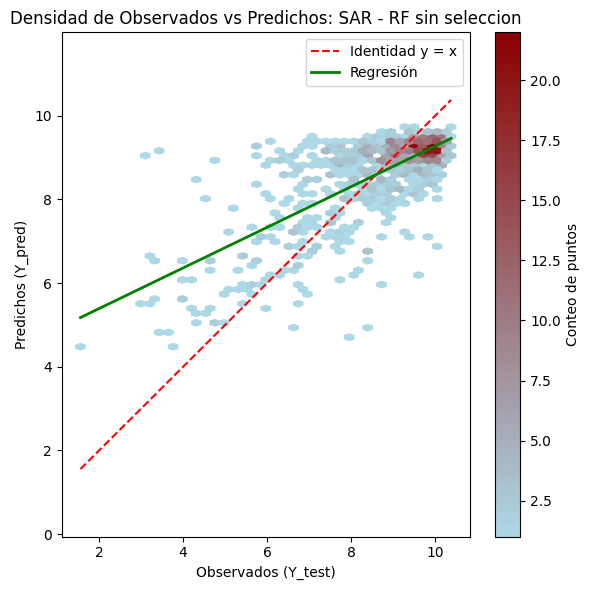

                   MODELO     Y_test    Y_pred
0  SAR - RF sin seleccion   8.031570  9.070646
1  SAR - RF sin seleccion  10.206363  9.213127
2  SAR - RF sin seleccion   9.745593  9.468898
3  SAR - RF sin seleccion  10.003646  9.538102
4  SAR - RF sin seleccion   8.310349  8.210656


In [12]:
from scipy.stats import linregress
from matplotlib.colors import LinearSegmentedColormap
# Supón que ya tienes Y_test y Y_pred definidos
name_modelo = "SAR - RF sin seleccion"

# Crear el DataFrame con las observaciones y predicciones
rf1_pred = pd.DataFrame({
    "MODELO": name_modelo,
    "Y_test": Y_test,
    "Y_pred": Y_pred
})


# Línea de identidad y = x
min_val = min(rf1_pred["Y_test"].min(), rf1_pred["Y_pred"].min())
max_val = max(rf1_pred["Y_test"].max(), rf1_pred["Y_pred"].max())
slope, intercept, _, _, _ = linregress(rf1_pred["Y_test"], rf1_pred["Y_pred"])
reg_x = np.array([min_val, max_val])
reg_y = slope * reg_x + intercept

cmap_yellow_orange = LinearSegmentedColormap.from_list(
    "yellow_orange", ["lightblue", "darkred"]
)
# 2️⃣ Mapa de calor (hexbin) para ver densidad de puntos
plt.figure(figsize=(6,6))
hb = plt.hexbin(
    rf1_pred["Y_test"],
    rf1_pred["Y_pred"],
    gridsize=40,
    cmap=cmap_yellow_orange,
    mincnt=1
)
plt.colorbar(hb, label="Conteo de puntos")

# Línea identidad y = x
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Identidad y = x")

# Línea de regresión
plt.plot(reg_x, reg_y, color="green", linewidth=2, label=f"Regresión")

plt.xlabel("Observados (Y_test)")
plt.ylabel("Predichos (Y_pred)")
plt.title(f"Densidad de Observados vs Predichos: {name_modelo}")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()
# Mostrar las primeras filas del DataFrame
print(rf1_pred.head())

In [13]:
importance_df = pd.DataFrame({'Variable': variables_predictoras, 'Importancia': final_model_rf_1.feature_importances_})

importance_rf1= importance_df.sort_values(by='Importancia', ascending=False)
importance_rf1["Importancia"].mean()

0.02941176470588235

In [14]:
importance_rf1

,Variable,Importancia
11,B12,0.236071
25,lat,0.074075
17,GCI,0.067823
5,B11,0.065753
24,lon,0.064194
14,B4,0.033340
23,elevation,0.028923
22,Slope,0.028365
20,NDVI,0.022097
13,B3,0.021650


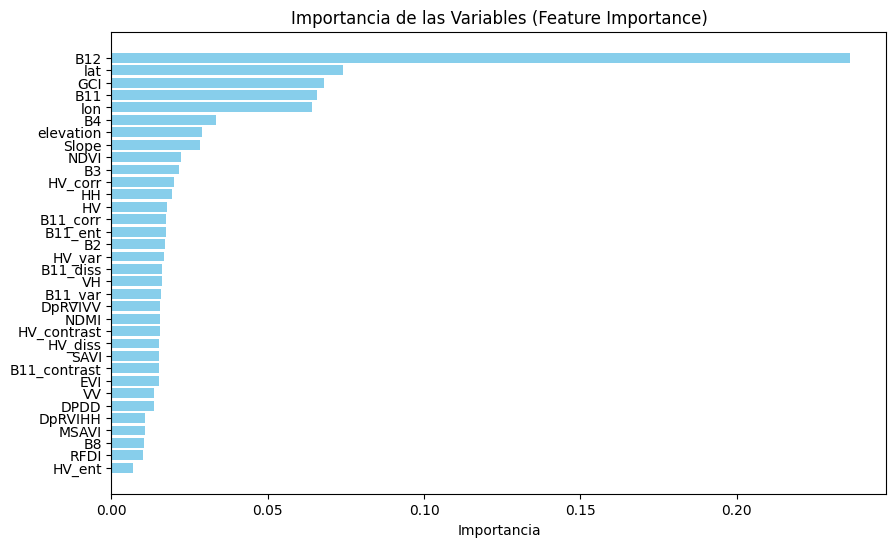

In [15]:

plt.figure(figsize=(10, 6))
plt.barh(importance_rf1['Variable'], importance_rf1['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Variables (Feature Importance)')
plt.gca().invert_yaxis()  # Para mostrar las variables más importantes en la parte superior
plt.show()

## Random Forest - Selección de variables

In [16]:
mlflow.sklearn.autolog(disable=True)

### Selección de variables

In [17]:
variables_predictoras =["B12", "lat", "B11", "lon", "GCI", "B4", "elevation"] 

variable_objetivo =  'N_efectivo_estratos' # variable objetivo

# Se transforma a un array numpy
X = np.array(df_gedi[variables_predictoras] )
Y = np.array(df_gedi[variable_objetivo] )
# 2️⃣ Divide los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=593)

### Creación de ambiente en optuna

In [18]:
# Crear la "study" para realizar la optimización bayesiana
from optuna.samplers import TPESampler
sampler = TPESampler(seed=593)

study_rf2 = optuna.create_study(direction='minimize', sampler = sampler)  # Queremos minimizar el MAPE

[I 2025-05-22 10:01:55,036] A new study created in memory with name: no-name-f6ada364-e8c4-44ad-ae71-49c03310e926


#### Inicio de busqueda de parámetros

Se establecen los hiperparámetros y un total de 200 iteraciones hasta seleccionar la mejor combinación. En este caso se usará la función de Coste MAPE que es el error porcentual promedio, y se debe buscar minimizarlo. En este caso se trabajará con Random Forest, con un total de 5 hiper parámetros.

In [19]:


# Semilla para reproducibilidad
np.random.seed(593)

# K-Fold para CV
kf = KFold(n_splits=5, shuffle=True, random_state=593)

# Función objetivo
def objective(trial):
    # 1️⃣ Sugerencia de hiperparámetros
    n_estimators       = trial.suggest_int("n_estimators",       100, 800)
    max_depth          = trial.suggest_int("max_depth",          50,   200)
    min_samples_split  = trial.suggest_int("min_samples_split",  2,   15)
    min_samples_leaf   = trial.suggest_int("min_samples_leaf",   2,   15)
    max_features       = trial.suggest_int("max_features",       1,   6)

    # (Opcional) resembrar numpy para cada trial
    np.random.seed(593)

    # 2️⃣ Crear y configurar el modelo
    model = RandomForestRegressor(
        n_estimators      = n_estimators,
        max_depth         = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf  = min_samples_leaf,
        max_features      = max_features,
        random_state      = 593,
        n_jobs            = -1      # paraleliza árboles en CPU
    )

    # Listas para métricas
    rmse_scores   = []
    rrmse_scores  = []
    mape_scores   = []
    r2_scores     = []
    kge_scores    = []

    # 3️⃣ CV manual con escalado en cada fold
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_va = X_train[train_idx], X_train[val_idx]
        y_tr, y_va = Y_train[train_idx], Y_train[val_idx]

        scaler   = StandardScaler().fit(X_tr)
        X_tr_sc  = scaler.transform(X_tr)
        X_va_sc  = scaler.transform(X_va)

        model.fit(X_tr_sc, y_tr)
        y_pred = model.predict(X_va_sc)

        # Calcular métricas
        rmse  = root_mean_squared_error(y_va, y_pred)
        rrmse = rmse / y_va.mean()
        mape  = mean_absolute_percentage_error(y_va, y_pred) * 100
        r2    = r2_score(y_va, y_pred)
        kge   = kling_gupta_efficiency(y_va, y_pred)

        rmse_scores.append(rmse)
        rrmse_scores.append(rrmse)
        mape_scores.append(mape)
        r2_scores.append(r2)
        kge_scores.append(kge)

    # 4️⃣ Agregar atributos al trial
    trial.set_user_attr("mean_rmse",  np.mean(rmse_scores))
    trial.set_user_attr("sd_rmse",    np.std(rmse_scores))
    trial.set_user_attr("mean_rrmse", np.mean(rrmse_scores))
    trial.set_user_attr("sd_rrmse",   np.std(rrmse_scores))
    trial.set_user_attr("mean_mape",  np.mean(mape_scores))
    trial.set_user_attr("sd_mape",    np.std(mape_scores))
    trial.set_user_attr("mean_r2",    np.mean(r2_scores))
    trial.set_user_attr("sd_r2",      np.std(r2_scores))
    trial.set_user_attr("mean_kge",   np.mean(kge_scores))
    trial.set_user_attr("sd_kge",     np.std(kge_scores))

    # 5️⃣ Retornar la métrica a optimizar
    return np.mean(mape_scores)

# 6️⃣ Ejecutar la optimización en paralelo (4 hilos)
study_rf2.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 10
)

# Resultados finales
print("Mejor MAPE encontrado: ", study_rf2.best_value)
print("Mejores hiperparámetros: ", study_rf2.best_params)

[I 2025-05-22 10:02:07,644] Trial 1 finished with value: 10.905709144109746 and parameters: {'n_estimators': 127, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 1}. Best is trial 1 with value: 10.905709144109746.
[I 2025-05-22 10:02:10,329] Trial 9 finished with value: 10.801089167398167 and parameters: {'n_estimators': 184, 'max_depth': 53, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': 5}. Best is trial 9 with value: 10.801089167398167.
[I 2025-05-22 10:02:10,329] Trial 9 finished with value: 10.801089167398167 and parameters: {'n_estimators': 184, 'max_depth': 53, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': 5}. Best is trial 9 with value: 10.801089167398167.
[I 2025-05-22 10:02:12,678] Trial 0 finished with value: 10.853404495537536 and parameters: {'n_estimators': 210, 'max_depth': 93, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 2}. Best is trial 9 with value: 10.801089167398167.
[I 2025-05-

Mejor MAPE encontrado:  10.626156606963297
Mejores hiperparámetros:  {'n_estimators': 346, 'max_depth': 55, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 3}


#### Evolución de iteraciones

In [20]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study_rf2)

#### Extracción de métricas

In [21]:
# 8️⃣ Imprimir los mejores hiperparámetros encontrados, la métrica objetivo y las métricas personalizadas
print("\n🔍 Mejores hiperparámetros encontrados:")
best_params = study_rf2.best_params
best_mae = study_rf2.best_value  # Esta es la mejor métrica (RMSE) obtenida
best_trial = study_rf2.best_trial  # El mejor trial, que tiene toda la información

# Imprimir los hiperparámetros y la métrica principal
print(f"Hiperparámetros: {best_params}")
print(f"Mejor puntuación (RMSE): {best_mae}")
# Imprimir las métricas registradas con set_user_attr
print("\n🔍 Métricas adicionales registradas en set_user_attr:")
for attr_name, attr_value in best_trial.user_attrs.items():
    print(f"{attr_name}: {attr_value}")


🔍 Mejores hiperparámetros encontrados:
Hiperparámetros: {'n_estimators': 346, 'max_depth': 55, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 3}
Mejor puntuación (RMSE): 10.626156606963297

🔍 Métricas adicionales registradas en set_user_attr:
mean_rmse: 1.0531218825648103
sd_rmse: 0.03952494179631117
mean_rrmse: 0.12104885254896987
sd_rrmse: 0.00462723297873283
mean_mape: 10.626156606963297
sd_mape: 0.49179444717713594
mean_r2: 0.46265191833674546
sd_r2: 0.04381300107644592
mean_kge: 0.5625160632262571
sd_kge: 0.03917378950640327


#### Test con 20% de datos

Se usa los mejores parámetros encontrados para hacer una evaluación con los datos de rpueba. Esta corrida se guarda en MlFlows.

In [22]:
# 1️⃣ Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2️⃣ Activar autolog de MLflow (registra modelo, métricas y parámetros automáticamente)
mlflow.sklearn.autolog()

# Nombre del modelo (tag)
modelo = "SAR - RF con seleccion"

# 1️⃣ Escalar los datos
scaler         = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2️⃣ Activar autolog de MLflow (registra automáticamente parámetros, métricas y modelo)
mlflow.sklearn.autolog()

# 3️⃣ Iniciar la corrida MLflow
with mlflow.start_run(run_name="rf_final_with_optuna_params_select2"):
    # 🔖 Etiquetar el nombre de tu modelo
    mlflow.set_tag("rf_select_variables2", modelo)

    # 🔹 Registrar los hiperparámetros óptimos
    mlflow.log_params(best_params)

    # 🔹 Crear y entrenar el modelo
    final_model_rf_2 = RandomForestRegressor(
        n_estimators       = best_params['n_estimators'],
        max_depth          = best_params['max_depth'],
        min_samples_split  = best_params['min_samples_split'],
        min_samples_leaf   = best_params['min_samples_leaf'],
        max_features       = best_params['max_features'],
        random_state       = 593,
        n_jobs             = -1
    )
    final_model_rf_2.fit(X_train_scaled, Y_train)

    # 🔹 Predecir sobre el conjunto de prueba
    Y_pred = final_model_rf_2.predict(X_test_scaled)

    # 🔹 Calcular las métricas solicitadas
    r2   = r2_score(Y_test, Y_pred)
    rmse = root_mean_squared_error(Y_test, Y_pred)
    mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100
    kge  = kling_gupta_efficiency(Y_test, Y_pred)

    # 🔹 Registrar las métricas en MLflow
    mlflow.log_metric("r2",   r2)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("kge",  kge)

    # 🔹 (Opcional) guardar el modelo explícitamente
    mlflow.sklearn.log_model(final_model_rf_2, artifact_path="model")

    # 🔹 Mostrar las métricas en consola con formato
    print(
        "╔══════════════════════════╗\n"
        "║   Métricas del modelo    ║\n"
        "╠══════════════════════════╣\n"
        f"║ R²   : {r2:8.3f}        ║\n"
        f"║ RMSE : {rmse:8.3f}        ║\n"
        f"║ MAPE : {mape:8.2f} %     ║\n"
        f"║ KGE  : {kge:8.3f}        ║\n"
        "╚══════════════════════════╝"
    )

2025/05/22 10:08:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


╔══════════════════════════╗
║   Métricas del modelo    ║
╠══════════════════════════╣
║ R²   :    0.496        ║
║ RMSE :    1.059        ║
║ MAPE :    10.63 %     ║
║ KGE  :    0.598        ║
╚══════════════════════════╝


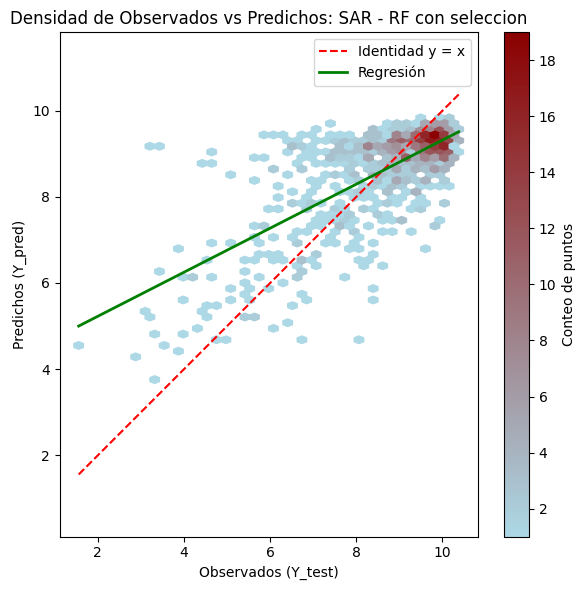

                   MODELO     Y_test    Y_pred
0  SAR - RF sin seleccion   8.031570  9.070646
1  SAR - RF sin seleccion  10.206363  9.213127
2  SAR - RF sin seleccion   9.745593  9.468898
3  SAR - RF sin seleccion  10.003646  9.538102
4  SAR - RF sin seleccion   8.310349  8.210656


In [23]:
from scipy.stats import linregress
from matplotlib.colors import LinearSegmentedColormap
# Supón que ya tienes Y_test y Y_pred definidos
name_modelo = "SAR - RF con seleccion"

# Crear el DataFrame con las observaciones y predicciones
rf2_pred = pd.DataFrame({
    "MODELO": name_modelo,
    "Y_test": Y_test,
    "Y_pred": Y_pred
})


# Línea de identidad y = x
min_val = min(rf2_pred["Y_test"].min(), rf2_pred["Y_pred"].min())
max_val = max(rf2_pred["Y_test"].max(), rf2_pred["Y_pred"].max())
slope, intercept, _, _, _ = linregress(rf2_pred["Y_test"], rf2_pred["Y_pred"])
reg_x = np.array([min_val, max_val])
reg_y = slope * reg_x + intercept

cmap_yellow_orange = LinearSegmentedColormap.from_list(
    "yellow_orange", ["lightblue", "darkred"]
)
# 2️⃣ Mapa de calor (hexbin) para ver densidad de puntos
plt.figure(figsize=(6,6))
hb = plt.hexbin(
    rf2_pred["Y_test"],
    rf2_pred["Y_pred"],
    gridsize=40,
    cmap=cmap_yellow_orange,
    mincnt=1
)
plt.colorbar(hb, label="Conteo de puntos")

# Línea identidad y = x
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Identidad y = x")

# Línea de regresión
plt.plot(reg_x, reg_y, color="green", linewidth=2, label=f"Regresión")

plt.xlabel("Observados (Y_test)")
plt.ylabel("Predichos (Y_pred)")
plt.title(f"Densidad de Observados vs Predichos: {name_modelo}")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()
# Mostrar las primeras filas del DataFrame
print(rf1_pred.head())

In [24]:
importance_df = pd.DataFrame({'Variable': variables_predictoras, 'Importancia': final_model_rf_2.feature_importances_})

importance_rf2= importance_df.sort_values(by='Importancia', ascending=False)
importance_rf2["Importancia"].mean()

0.14285714285714282

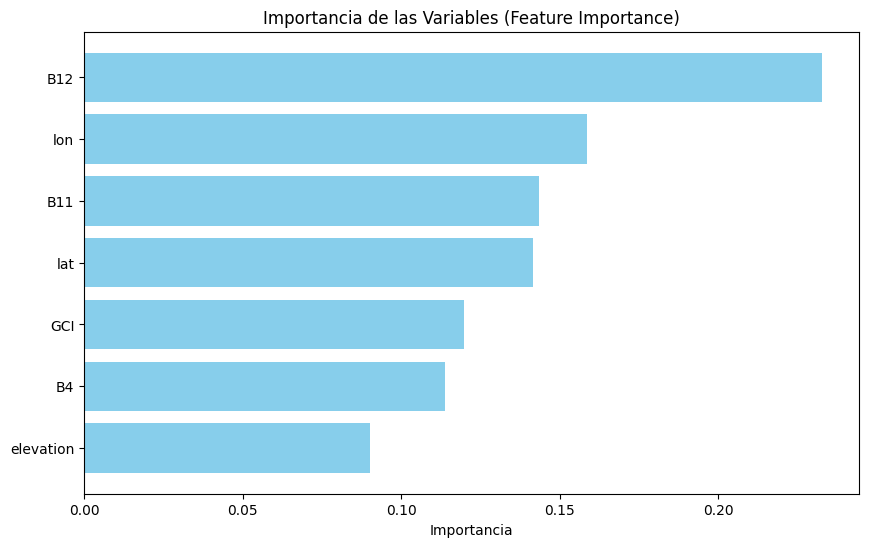

In [25]:

plt.figure(figsize=(10, 6))
plt.barh(importance_rf2['Variable'], importance_rf2['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Variables (Feature Importance)')
plt.gca().invert_yaxis()  # Para mostrar las variables más importantes en la parte superior
plt.show()

## Entrenamiento de modelo Final

Una vez se haya seleccionado el modelo final con los mejores parámetros, se hace un entrenamiento del modelo usando todos los datos disponibles

In [26]:
X = df_gedi[variables_predictoras].values
Y = df_gedi[variable_objetivo].values

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1️⃣ Activar autolog de MLflow
mlflow.sklearn.autolog()

# 2️⃣ Iniciar corrida en MLflow
with mlflow.start_run(run_name="rf_final_total"):
    # 🔖 Etiquetar modelo
    mlflow.set_tag("model_selected", modelo)

    # 🔹 Registrar hiperparámetros
    mlflow.log_params(best_params)

    # 3️⃣ Crear y entrenar el modelo
    final_model_export = RandomForestRegressor(
        n_estimators      = best_params.get("n_estimators", 785),
        max_depth         = best_params.get("max_depth", 75),
        min_samples_split = best_params.get("min_samples_split", 2),
        min_samples_leaf  = best_params.get("min_samples_leaf", 2),
        max_features      = best_params.get("max_features", 2),
        random_state      = 593,
        n_jobs            = -1
    )
    final_model_export.fit(X_scaled, Y)

    # 4️⃣ Predecir en el mismo dataset
    Y_pred = final_model_export.predict(X_scaled)

    # 5️⃣ Calcular y loggear métricas
    r2   = r2_score(Y, Y_pred)
    rmse = root_mean_squared_error(Y, Y_pred)
    mape = mean_absolute_percentage_error(Y, Y_pred) * 100
    kge  = kling_gupta_efficiency(Y, Y_pred)

    mlflow.log_metric("r2",   r2)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("kge",  kge)

    # 6️⃣ Guardar el modelo explícitamente
    mlflow.sklearn.log_model(final_model_export, artifact_path="model")

    print(f"Run completed: {mlflow.active_run().info.run_id}")



2025/05/22 10:08:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run completed: b6e9b282656c465a8fb572ceece95505


In [28]:
import joblib
from sklearn.preprocessing import StandardScaler

# ... tras ajustar el scaler sobre X …
scaler = StandardScaler().fit(X)

# 1️⃣ Serializa el scaler a disco
joblib.dump(scaler, "scaler.pkl")
print("Scaler guardado en scaler.pkl")


Scaler guardado en scaler.pkl


In [27]:
import subprocess
# 1. Construye la ruta absoluta a mlruns (convierte '\' en '/')
project_root = os.getcwd()
mlruns_path  = os.path.join(project_root, "mlruns").replace("\\", "/")

# 2. Monta el comando tal cual lo harías en la terminal
cmd = [
    "mlflow", "ui",
    "--backend-store-uri",    f"file:///{mlruns_path}",
    "--default-artifact-root",f"file:///{mlruns_path}",
    "--port",                 "9090"
]

# 3. Lanza el proceso en background
#    stdout/stderr se envían a pipes; no bloquea la ejecución de la celda
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

print("✔ MLflow UI arrancado en http://localhost:9090")

✔ MLflow UI arrancado en http://localhost:9090
